In [16]:
# !pip install pandas
# !pip install numpy
# !pip install lightgbm
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install graphviz


In [17]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.info()) # 6,995,055개의 데이터
print(test_data.info()) # 1,747,688개의 데이터

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6995056 entries, 0 to 6995055
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
 2   label   int64 
dtypes: int64(1), object(2)
memory usage: 160.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747689 entries, 0 to 1747688
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   ID      object
 1   URL     object
dtypes: object(2)
memory usage: 26.7+ MB
None


In [18]:
train_data.head()

,ID,URL,label
0,TRAIN_0000000,poznan[.]wuoz[.]gov[.]pl,0
1,TRAIN_0000001,vill[.]okawa[.]kochi[.]jp,0
2,TRAIN_0000002,nationalfinance[.]co[.]om,0
3,TRAIN_0000003,town[.]ozora[.]hokkaido[.]jp,0
4,TRAIN_0000004,open24[.]ie-news[.]irish/online/Login,1


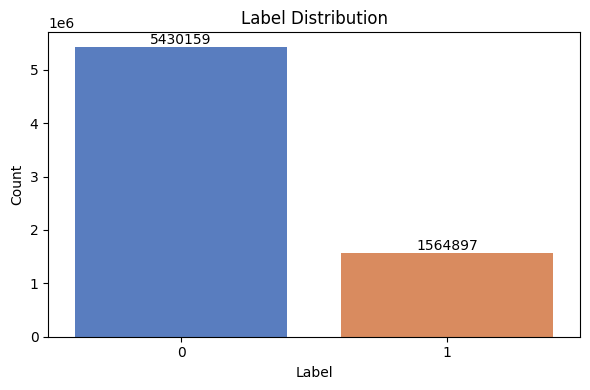

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  

ax = sns.countplot(
    x='label',
    hue='label',
    data=train_data,
    palette='muted',
    legend=False,  
)

plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,   # 막대 중앙 x 위치
        p.get_height() + 0.2,            # 막대 위쪽 y 위치
        f'{int(p.get_height())}',        # 개수 표시
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()

In [20]:
train_data['URL'] = train_data['URL'].str.replace('[.]', '.')
test_data['URL'] = test_data['URL'].str.replace('[.]', '.')

In [21]:
import re
import string
import math
from collections import Counter

# -----------------------------------
# URL 정규화
# -----------------------------------
def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# -----------------------------------
# 헬퍼 함수들
# -----------------------------------
def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    match = re.search(r'://([^/]+)', url)
    return match.group(1) if match else None

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def count_unique_chars(url):
    return len(set(url))

def extract_tld(url):
    match = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return match.group(1).lower() if match else None

def path_part(url):
    match = re.search(r'[^/]+/(.*)', url)
    return match.group(1) if match else ""

def query_part(url):
    match = re.search(r'\?(.*)', url)
    return match.group(1) if match else ""

def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = 0
    for count in counter.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def check_randomness(url):
    entropy = calculate_entropy(url)
    
    # 연속된 동일 문자 최대 길이
    max_consecutive = current = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current += 1
            max_consecutive = max(max_consecutive, current)
        else:
            current = 1
    
    # 숫자 ↔ 문자 전환 횟수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    # 무작위성 점수 (0~1 정규화)
    entropy_score     = min(entropy / 5.0, 1.0)
    consecutive_score = min(max_consecutive / 10.0, 1.0)
    transition_score  = min(transitions / 10.0, 1.0)
    
    randomness_score = (entropy_score * 0.5 +
                        (1 - consecutive_score) * 0.3 +
                        transition_score * 0.2)
    
    return randomness_score

# -----------------------------------
# 피처 엔지니어링 함수
# -----------------------------------
def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)
    
    # 길이 기반
    df['length']           = df['URL'].str.len()
    df['subdomain_count']  = df['URL'].str.split('.').str.len()
    df['num_digits']       = df['URL'].apply(count_digits)
    df['num_special_chars']= df['URL'].apply(count_special_chars)
    df['unique_chars']     = df['URL'].apply(count_unique_chars)
    
    # 도메인 관련
    df['domain']           = df['URL_norm'].apply(extract_domain)
    df['domain_length']    = df['domain'].astype(str).str.len()
    df['domain_has_digit'] = df['domain'].apply(has_digit)
    df['num_hyphens']      = df['URL'].str.count('-')
    df['num_underscores']  = df['URL'].str.count('_')
    
    # 특수 패턴
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')
    df['is_http']   = df['URL_norm'].str.startswith('http://')
    df['is_https']  = df['URL_norm'].str.startswith('https://')
    df['has_port']  = df['URL_norm'].str.contains(r':\d{2,5}')
    df['has_at']    = df['URL_norm'].str.contains('@')
    
    # 경로 & 쿼리
    df['path']         = df['URL_norm'].apply(path_part)
    df['path_length']  = df['path'].str.len()
    df['query']        = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params']   = df['query'].str.count('=')
    
    # TLD 및 키워드
    df['tld'] = df['URL_norm'].apply(extract_tld)
    
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )
    
    # 무작위성 점수
    df['randomness'] = df['URL'].apply(check_randomness)
    
    return df

# -----------------------------------
# 실행
# -----------------------------------
train_data = add_url_features(train_data)
test_data  = add_url_features(test_data)

print("Feature Engineering 완료!")
train_data.head()

Feature Engineering 완료!


,ID,URL,label,URL_norm,length,subdomain_count,num_digits,num_special_chars,unique_chars,domain,...,has_port,has_at,path,path_length,query,query_length,num_params,tld,has_phish_keyword,randomness
0,TRAIN_0000000,poznan.wuoz.gov.pl,0,http://poznan.wuoz.gov.pl,18,4,0,3,11,poznan.wuoz.gov.pl,...,False,False,/poznan.wuoz.gov.pl,19,,0,0,pl,False,0.600827
1,TRAIN_0000001,vill.okawa.kochi.jp,0,http://vill.okawa.kochi.jp,19,4,0,3,12,vill.okawa.kochi.jp,...,False,False,/vill.okawa.kochi.jp,20,,0,0,jp,False,0.587135
2,TRAIN_0000002,nationalfinance.co.om,0,http://nationalfinance.co.om,21,3,0,2,11,nationalfinance.co.om,...,False,False,/nationalfinance.co.om,22,,0,0,om,False,0.597280
3,TRAIN_0000003,town.ozora.hokkaido.jp,0,http://town.ozora.hokkaido.jp,22,4,0,3,14,town.ozora.hokkaido.jp,...,False,False,/town.ozora.hokkaido.jp,23,,0,0,jp,False,0.593377
4,TRAIN_0000004,open24.ie-news.irish/online/Login,1,http://open24.ie-news.irish/online/Login,33,3,2,5,17,open24.ie-news.irish,...,False,False,/open24.ie-news.irish/online/Login,34,,0,0,irish,True,0.667245


In [22]:
import warnings
import gc
import numpy as np
import pandas as pd
import re
import string
import math
from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

# =====================================================
# 1) URL 정규화
# =====================================================
def normalize_url(url):
    if not re.match(r'^https?://', url):
        return 'http://' + url
    return url

# =====================================================
# 2) 헬퍼 함수들
# =====================================================
def count_digits(url):
    return sum(char.isdigit() for char in url)

def count_special_chars(url):
    return sum(char in string.punctuation for char in url)

def extract_domain(url):
    m = re.search(r'://([^/]+)', url)
    return m.group(1) if m else None

def extract_tld(url):
    m = re.search(r'\.([a-zA-Z]{2,10})(?:/|$)', url)
    return m.group(1).lower() if m else None

def count_unique_chars(url):
    return len(set(url))

def has_digit(s):
    return any(c.isdigit() for c in str(s))

def path_part(url):
    m = re.search(r'[^/]+/(.*)', url)
    return m.group(1) if m else ""

def query_part(url):
    m = re.search(r'\?(.*)', url)
    return m.group(1) if m else ""

def calculate_entropy(url):
    counter = Counter(url)
    length = len(url)
    entropy = 0
    for count in counter.values():
        p = count / length
        entropy -= p * math.log2(p)
    return entropy

def check_randomness(url):
    entropy = calculate_entropy(url)
    
    # 연속 문자 최대 길이
    max_consecutive = current = 1
    for i in range(1, len(url)):
        if url[i].isalnum() and url[i-1].isalnum() and url[i].lower() == url[i-1].lower():
            current += 1
            max_consecutive = max(max_consecutive, current)
        else:
            current = 1
    
    # 숫자 ↔ 문자 전환 횟수
    transitions = 0
    for i in range(1, len(url)):
        if (url[i-1].isdigit() and url[i].isalpha()) or (url[i-1].isalpha() and url[i].isdigit()):
            transitions += 1
    
    entropy_score     = min(entropy / 5.0, 1.0)
    consecutive_score = min(max_consecutive / 10.0, 1.0)
    transition_score  = min(transitions / 10.0, 1.0)
    
    return (entropy_score * 0.5 +
            (1 - consecutive_score) * 0.3 +
            transition_score * 0.2)

# =====================================================
# 3) 피처 엔지니어링
# =====================================================
def add_url_features(df):
    df['URL_norm'] = df['URL'].apply(normalize_url)
    
    df['length']            = df['URL'].str.len()
    df['subdomain_count']   = df['URL'].str.split('.').str.len()
    df['num_digits']        = df['URL'].apply(count_digits)
    df['num_special_chars'] = df['URL'].apply(count_special_chars)
    df['unique_chars']      = df['URL'].apply(count_unique_chars)
    
    df['domain']            = df['URL_norm'].apply(extract_domain)
    df['domain_length']     = df['domain'].astype(str).str.len()
    df['domain_has_digit']  = df['domain'].apply(has_digit)
    df['num_hyphens']       = df['URL'].str.count('-')
    df['num_underscores']   = df['URL'].str.count('_')
    
    df['is_ip_url'] = df['URL_norm'].str.contains(r'^\d{1,3}(\.\d{1,3}){3}')
    df['is_http']   = df['URL_norm'].str.startswith('http://')
    df['is_https']  = df['URL_norm'].str.startswith('https://')
    df['has_port']  = df['URL_norm'].str.contains(r':\d{2,5}')
    df['has_at']    = df['URL_norm'].str.contains('@')
    
    df['path']         = df['URL_norm'].apply(path_part)
    df['path_length']  = df['path'].str.len()
    df['query']        = df['URL_norm'].apply(query_part)
    df['query_length'] = df['query'].str.len()
    df['num_params']   = df['query'].str.count('=')
    
    df['tld'] = df['URL_norm'].apply(extract_tld)
    
    phishing_keywords = ['login', 'secure', 'update', 'verify', 'account', 'bank',
                         'paypal', 'free', 'bonus', 'admin', 'redirect', 'auth',
                         'signin', 'server', 'click', 'immediate', 'confirm']
    df['has_phish_keyword'] = df['URL'].apply(
        lambda x: any(k in x.lower() for k in phishing_keywords)
    )
    
    df['randomness'] = df['URL'].apply(check_randomness)
    
    return df

# =====================================================
# 4) 피처 엔지니어링 실행 + TLD 인코딩
# =====================================================
df = add_url_features(train_data.copy())
le = LabelEncoder()
df['tld_encoded'] = le.fit_transform(df['tld'].astype(str))

# =====================================================
# 5) 피처 선택
# =====================================================
exclude_cols = ['ID', 'URL', 'URL_norm', 'domain', 'path', 'query', 'tld', 'label']
features = [c for c in df.columns if c not in exclude_cols]

X = df[features]
y = df['label']

# =====================================================
# 6) Train / Valid 분리
# =====================================================
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =====================================================
# 7) 모델 하이퍼파라미터 탐색 및 학습
# =====================================================
# LightGBM
lgb_params = {
    'num_leaves': [20, 31, 50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [300, 500],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.8, 0.9]
}
lgb_base = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, verbose=-1)
lgb_search = RandomizedSearchCV(lgb_base, lgb_params, n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=4)
lgb_search.fit(X_train, y_train)
lgb_model = lgb_search.best_estimator_

# XGBoost
xgb_params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.8, 0.9],
    'subsample': [0.8, 0.9]
}
xgb_base = XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=50)
xgb_search = RandomizedSearchCV(xgb_base, xgb_params, n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=4)
xgb_search.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
xgb_model = xgb_search.best_estimator_

# CatBoost
cat_params = {
    'iterations': [300, 500],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3]
}
cat_base = CatBoostClassifier(eval_metric='AUC', random_seed=42, logging_level='Silent', early_stopping_rounds=50)
cat_search = RandomizedSearchCV(cat_base, cat_params, n_iter=10, cv=3, scoring='f1', random_state=42, n_jobs=4)
cat_search.fit(X_train, y_train, eval_set=(X_valid, y_valid))
cat_model = cat_search.best_estimator_

# 메모리 정리
del lgb_search, xgb_search, cat_search
gc.collect()

print("모든 SearchCV 완료 및 메모리 정리 완료!")

모든 SearchCV 완료 및 메모리 정리 완료!


앙상블 예측 중... (수동 Soft Voting)
Ensemble (Manual Soft Voting) - Accuracy: 0.93031, F1-Score: 0.82954

=== Model Performance Comparison ===
          Accuracy  F1-Score
XGBoost    0.93038   0.83010
Ensemble   0.93031   0.82954
CatBoost   0.92889   0.82559
LightGBM   0.92751   0.82249

Best Model (by F1-Score): XGBoost (F1 = 0.83010)


<Figure size 1000x800 with 0 Axes>

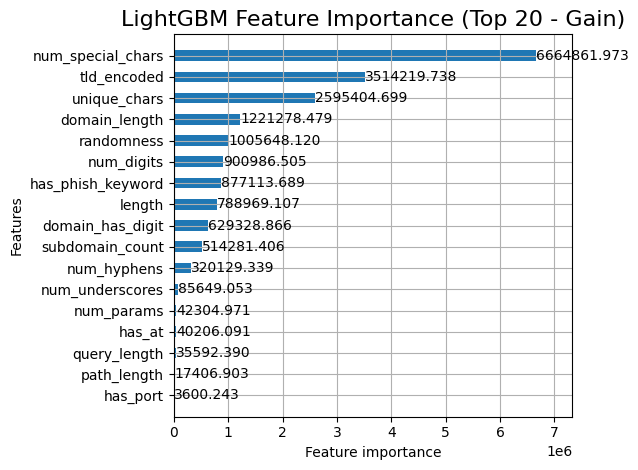


Best Parameters:


NameError: name 'lgb_search' is not defined

In [24]:
# =====================================================
# 8) 수동 Soft Voting 앙상블
# =====================================================
print("앙상블 예측 중... (수동 Soft Voting)")

val_lgb = lgb_model.predict_proba(X_valid)[:, 1]
val_xgb = xgb_model.predict_proba(X_valid)[:, 1]
val_cat = cat_model.predict_proba(X_valid)[:, 1]

# 단순 평균 앙상블 (필요시 가중치 조정 가능)
ensemble_proba = (val_lgb + val_xgb + val_cat) / 3
# 예: CatBoost가 더 좋으면 → ensemble_proba = val_lgb*0.3 + val_xgb*0.3 + val_cat*0.4

ensemble_pred = (ensemble_proba > 0.5).astype(int)

ensemble_acc = accuracy_score(y_valid, ensemble_pred)
ensemble_f1  = f1_score(y_valid, ensemble_pred)

print(f"Ensemble (Manual Soft Voting) - Accuracy: {ensemble_acc:.5f}, F1-Score: {ensemble_f1:.5f}\n")

# =====================================================
# 9) 개별 모델 및 앙상블 성능 비교
# =====================================================
pred_lgb = lgb_model.predict_proba(X_valid)[:, 1]
pred_xgb = xgb_model.predict_proba(X_valid)[:, 1]
pred_cat = cat_model.predict_proba(X_valid)[:, 1]

lgb_acc = accuracy_score(y_valid, (pred_lgb > 0.5).astype(int))
lgb_f1  = f1_score(y_valid, (pred_lgb > 0.5).astype(int))

xgb_acc = accuracy_score(y_valid, (pred_xgb > 0.5).astype(int))
xgb_f1  = f1_score(y_valid, (pred_xgb > 0.5).astype(int))

cat_acc = accuracy_score(y_valid, (pred_cat > 0.5).astype(int))
cat_f1  = f1_score(y_valid, (pred_cat > 0.5).astype(int))

results = {
    'LightGBM':  {'Accuracy': lgb_acc,  'F1-Score': lgb_f1},
    'XGBoost':   {'Accuracy': xgb_acc,  'F1-Score': xgb_f1},
    'CatBoost':  {'Accuracy': cat_acc,  'F1-Score': cat_f1},
    'Ensemble':  {'Accuracy': ensemble_acc, 'F1-Score': ensemble_f1}
}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='F1-Score', ascending=False)

print("=== Model Performance Comparison ===")
print(results_df.round(5))

best_model_name = results_df['F1-Score'].idxmax()
best_f1 = results_df.loc[best_model_name, 'F1-Score']
print(f"\nBest Model (by F1-Score): {best_model_name} (F1 = {best_f1:.5f})")

# =====================================================
# 10) LightGBM Feature Importance 시각화
# =====================================================
plt.figure(figsize=(10, 8))
lgb.plot_importance(lgb_model, max_num_features=20, height=0.5, importance_type='gain')
plt.title("LightGBM Feature Importance (Top 20 - Gain)", fontsize=16)
plt.tight_layout()
plt.show()

# =====================================================
# 11) 최적 하이퍼파라미터 출력
# =====================================================
print("\nBest Parameters:")
print("LightGBM :", lgb_search.best_params_)
print("XGBoost  :", xgb_search.best_params_)
print("CatBoost :", cat_search.best_params_)

In [26]:
# ------------------------------
# 1) test feature engineering
# ------------------------------
test_df = add_url_features(test_data.copy())

# ------------------------------
# 2) TLD 처리 (train에 없는 TLD → unknown 처리)
# ------------------------------
# train에서 사용한 LabelEncoder에 unknown 클래스 추가
test_df['tld_fixed'] = test_df['tld'].astype(str)

# train에 없던 새로운 tld는 "unknown"으로 대체
test_df.loc[~test_df['tld_fixed'].isin(le.classes_), 'tld_fixed'] = "unknown"

# LabelEncoder에 unknown 클래스 추가 (이미 있으면 무시됨)
if "unknown" not in le.classes_:
    le.classes_ = np.append(le.classes_, "unknown")

# 인코딩
test_df['tld_encoded'] = le.transform(test_df['tld_fixed'])

# ------------------------------
# 3) train에서 사용했던 피처 리스트 그대로 사용
# ------------------------------
# (이전에 정의한 features 변수 재사용)
X_test = test_df[features]   # ← 여기서 features는 train에서 만든 리스트

# ------------------------------
# 4) 예측 (여기서는 수동 Soft Voting 앙상블 사용)
# ------------------------------
test_lgb = lgb_model.predict_proba(X_test)[:, 1]
test_xgb = xgb_model.predict_proba(X_test)[:, 1]
test_cat = cat_model.predict_proba(X_test)[:, 1]

# 검증에서 가장 좋았던 가중치로 앙상블 (필요시 수정 가능)
test_proba = (test_lgb + test_xgb + test_cat) / 3
# test_proba = test_lgb*0.35 + test_xgb*0.3 + test_cat*0.35   # 더 정밀하게 하고 싶으면 이렇게

# ------------------------------
# 5) 제출 파일 생성
# ------------------------------
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'probability': test_proba                    
})

submission.to_csv("submission.csv", index=False)
print("제출 파일 저장 완료 → submission.csv")
submission.head()

제출 파일 저장 완료 → submission.csv


,ID,probability
0,TEST_0000000,0.127224
1,TEST_0000001,0.055399
2,TEST_0000002,0.002735
3,TEST_0000003,0.008847
4,TEST_0000004,0.078584
